In [13]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from matplotlib.pyplot import subplots

Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame({'age': age_grid})

First computational visit.

Scatter plot.

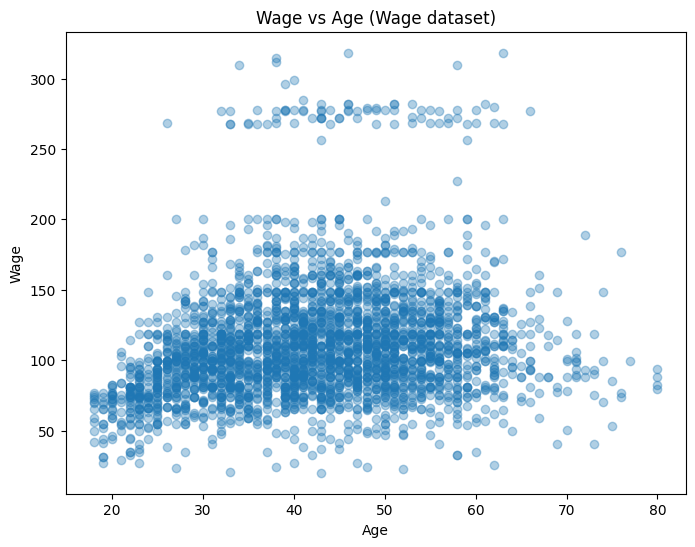

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(age, y, alpha=0.35)
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title("Wage vs Age (Wage dataset)")
plt.show()

Step 2. Let's build our linear model.

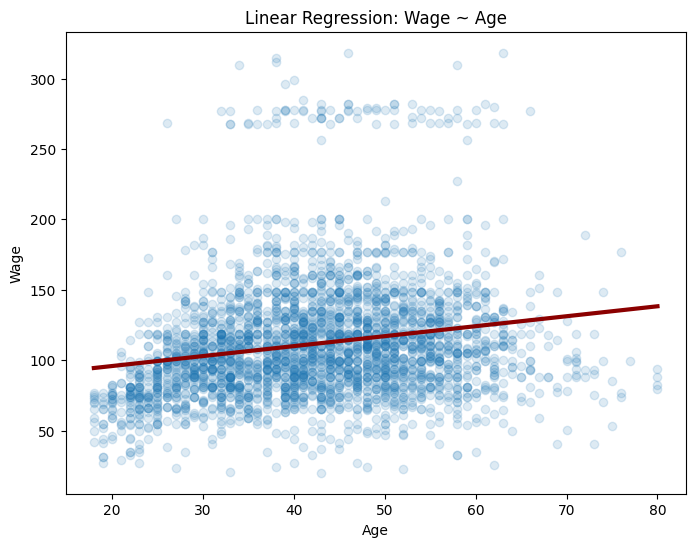

In [15]:
X = sm.add_constant(Wage[['age']])   # design matrix with intercept
lm = sm.OLS(y, X).fit()

# Prediction grid
X_new = sm.add_constant(pd.DataFrame({'age': age_grid}))

y_hat = lm.predict(X_new)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(age, y, alpha=0.15)#, color='gray')
plt.plot(age_grid, y_hat, linewidth=3, color ='darkred')
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title("Linear Regression: Wage ~ Age")
plt.show()

This certainly looks linear. How bad are we doing here? 

Let's compute some residuals. 

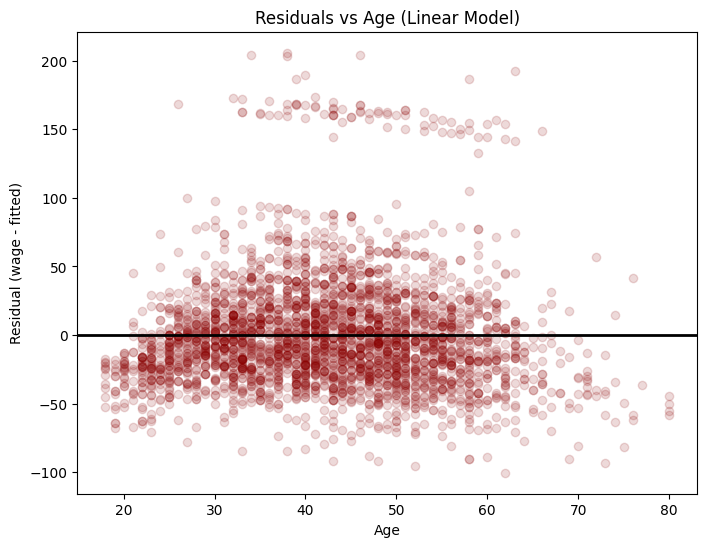

In [16]:
res = y - lm.fittedvalues

plt.figure(figsize=(8, 6))
plt.scatter(age, res, alpha=0.15, color = 'darkred')
plt.axhline(0, color='black', linewidth=2)
plt.xlabel("Age")
plt.ylabel("Residual (wage - fitted)")
plt.title("Residuals vs Age (Linear Model)")
plt.show()

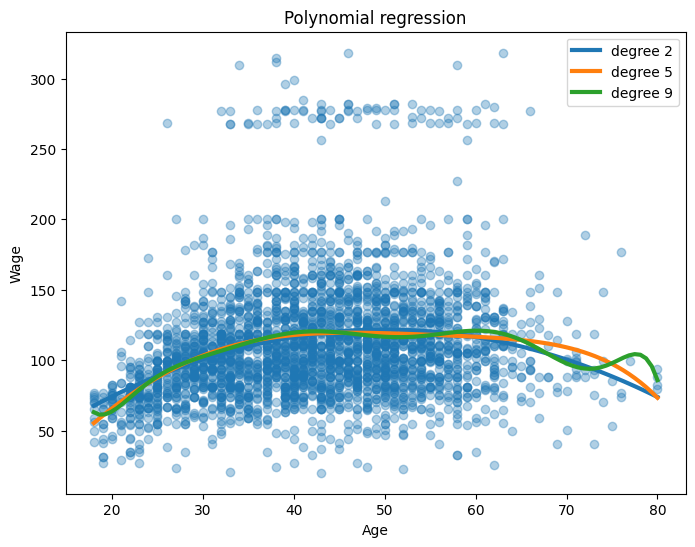

In [17]:
# Polynomial Excursion 

degrees = [2, 5, 9]

plt.figure(figsize=(8, 6))
plt.scatter(age, y, alpha=0.35)

for d in degrees:
    basis = MS([poly('age', degree=d)]).fit(Wage)
    X = sm.add_constant(basis.transform(Wage))
    X_new = sm.add_constant(basis.transform(age_df), has_constant='add')

    model = sm.OLS(y, X).fit()
    
    X_new_aligned = X_new.reindex(columns=X.columns, fill_value=0)
    y_hat = model.predict(X_new_aligned)

    plt.plot(age_grid, y_hat, linewidth=3, label=f"degree {d}")

plt.xlabel("Age")
plt.ylabel("Wage")
plt.title("Polynomial regression")
plt.legend()
plt.show()


Generalized Additive Models

Let's start with age, then include year and education. 

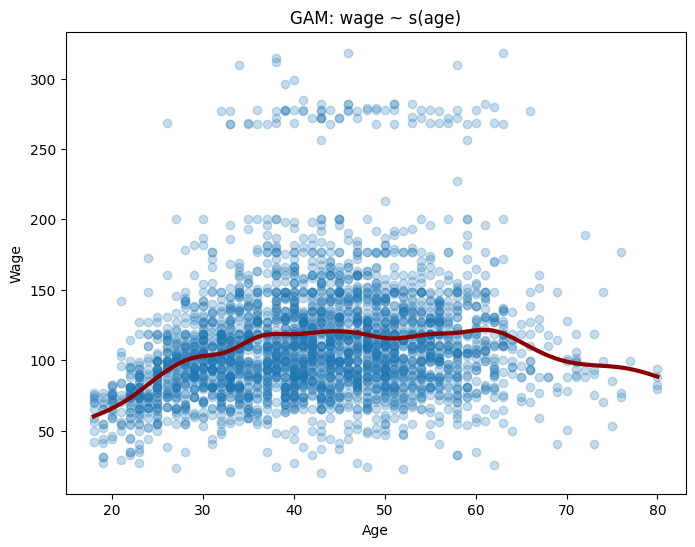

In [18]:
from pygam import LinearGAM, s, f

X_age = Wage[['age']].to_numpy()
gam_age = LinearGAM(s(0)).fit(X_age, y)

Xg = age_grid.reshape(-1, 1)
y_hat = gam_age.predict(Xg)

plt.figure(figsize=(8, 6))
plt.scatter(Wage['age'], y, alpha=0.25)
plt.plot(age_grid, y_hat, color='darkred', linewidth=3)
plt.xlabel("Age"); plt.ylabel("Wage")
plt.title("GAM: wage ~ s(age)")
plt.show()


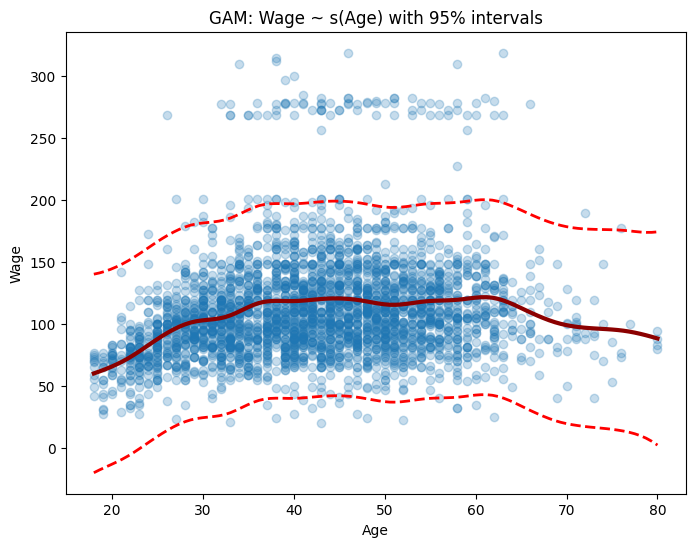

In [19]:
# and let's plot confidence bands 

intervals = gam_age.prediction_intervals(Xg, width=0.95)

plt.figure(figsize=(8, 6))
plt.scatter(age, y, alpha=0.25)
plt.plot(age_grid, y_hat, color='darkred', linewidth=3)
plt.plot(age_grid, intervals[:, 0], color='red', linestyle='--', linewidth=2)
plt.plot(age_grid, intervals[:, 1], color='red', linestyle='--', linewidth=2)
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title("GAM: Wage ~ s(Age) with 95% intervals")
plt.show()


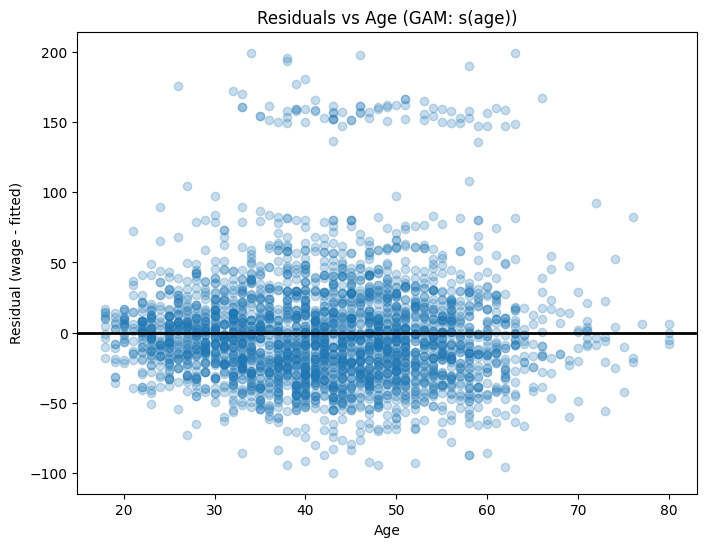

In [20]:
resid_gam = y - gam_age.predict(X_age)

plt.figure(figsize=(8, 6))
plt.scatter(Wage['age'], resid_gam, alpha=0.25)
plt.axhline(0, color='black', linewidth=2)
plt.xlabel("Age"); plt.ylabel("Residual (wage - fitted)")
plt.title("Residuals vs Age (GAM: s(age))")
plt.show()


In [21]:
# fit age year 

from pygam import LinearGAM, s

X_ay = Wage[['age', 'year']].to_numpy()
gam_ay = LinearGAM(s(0) + s(1)).fit(X_ay, y)


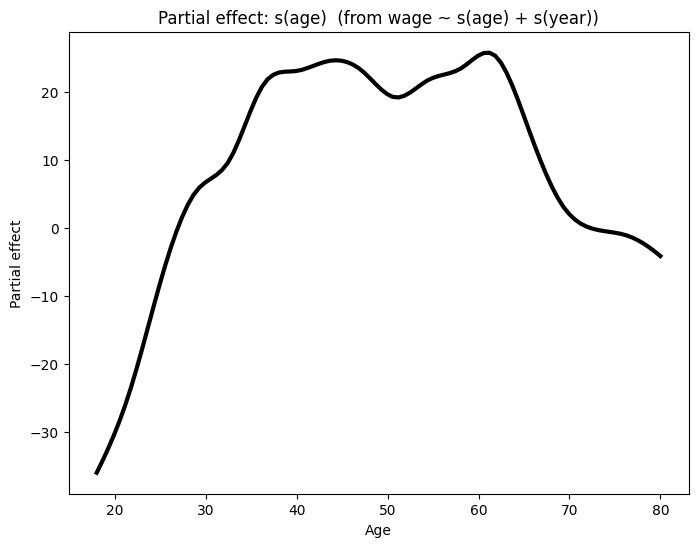

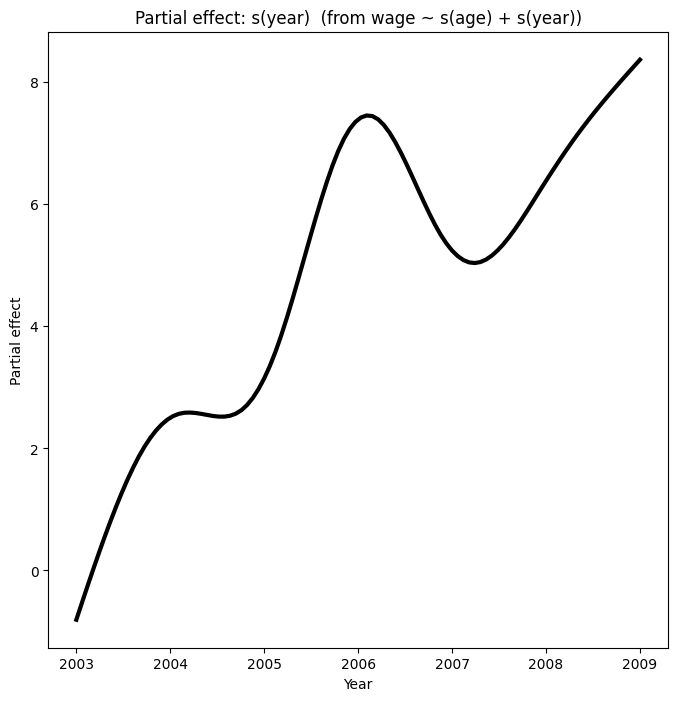

In [22]:
# plot the partial effect of age and year

# Partial effect of age
XX_age = gam_ay.generate_X_grid(term=0)
p_age = gam_ay.partial_dependence(term=0, X=XX_age)

plt.figure(figsize=(8, 6))
plt.plot(XX_age[:, 0], p_age, color='black', linewidth=3)
plt.xlabel("Age"); plt.ylabel("Partial effect")
plt.title("Partial effect: s(age)  (from wage ~ s(age) + s(year))")
plt.show()

# Partial effect of year
XX_year = gam_ay.generate_X_grid(term=1)
p_year = gam_ay.partial_dependence(term=1, X=XX_year)

plt.figure(figsize=(8, 8))
plt.plot(XX_year[:, 1], p_year, color='black', linewidth=3)
plt.xlabel("Year"); plt.ylabel("Partial effect")
plt.title("Partial effect: s(year)  (from wage ~ s(age) + s(year))")
plt.show()


In [23]:
# and add education

from pygam import LinearGAM, s, f

edu = Wage['education'].astype('category')
edu_codes = edu.cat.codes.to_numpy()

if (edu_codes < 0).any():
    raise ValueError("education has missing values; drop/fill before coding.")

X_aye = np.column_stack([
    Wage['age'].to_numpy(),
    Wage['year'].to_numpy(),
    edu_codes
])

gam_aye = LinearGAM(s(0) + s(1) + f(2)).fit(X_aye, y)

print("Education levels (code -> level):")
for i, lvl in enumerate(edu.cat.categories):
    print(i, lvl)


Education levels (code -> level):
0 1. < HS Grad
1 2. HS Grad
2 3. Some College
3 4. College Grad
4 5. Advanced Degree


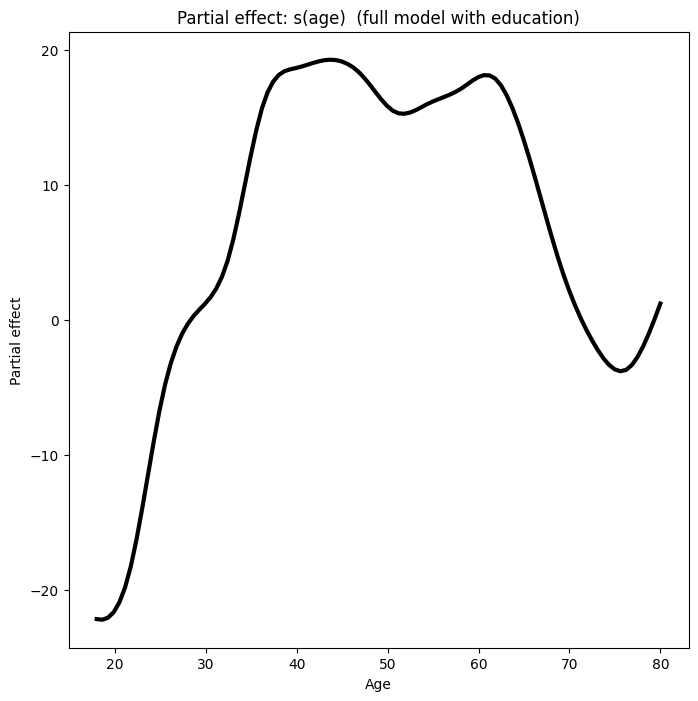

In [24]:
XX_age = gam_aye.generate_X_grid(term=0)
p_age = gam_aye.partial_dependence(term=0, X=XX_age)

plt.figure(figsize=(8, 8))
plt.plot(XX_age[:, 0], p_age, color='black', linewidth=3)
plt.xlabel("Age"); plt.ylabel("Partial effect")
plt.title("Partial effect: s(age)  (full model with education)")
plt.show()
